In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D


In [2]:
labels = ['NORMAL', 'KNOCKKNEES']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = "X:/miniproject/train"
test = "X:/miniproject/test"
val = "X:/miniproject/val"

In [4]:
train_normal = "X:/miniproject/train/normal"
train_knockknees = "X:/miniproject/train/knockknees"

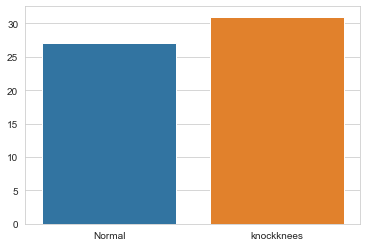

In [5]:
import seaborn as sns
sns.set_style('whitegrid')
sns.barplot(x=['Normal','knockknees'],y=[len(train_normal), len(train_knockknees )])

In [6]:
input_height=128
input_width=128
batch_size=32

In [7]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train, 
                                                             color_mode='grayscale', 
                                                             image_size=(input_height, input_width), 
                                                             batch_size=batch_size)

test_ds=tf.keras.preprocessing.image_dataset_from_directory(test, 
                                                             color_mode='grayscale', 
                                                             image_size=(input_height, input_width), 
                                                             batch_size=batch_size)

val_ds=tf.keras.preprocessing.image_dataset_from_directory(val, 
                                                             color_mode='grayscale', 
                                                             image_size=(input_height, input_width), 
                                                             batch_size=batch_size)

Found 3185 files belonging to 2 classes.
Found 2616 files belonging to 2 classes.
Found 72 files belonging to 2 classes.


In [8]:


train_ds.class_names



['knockknees', 'normal']

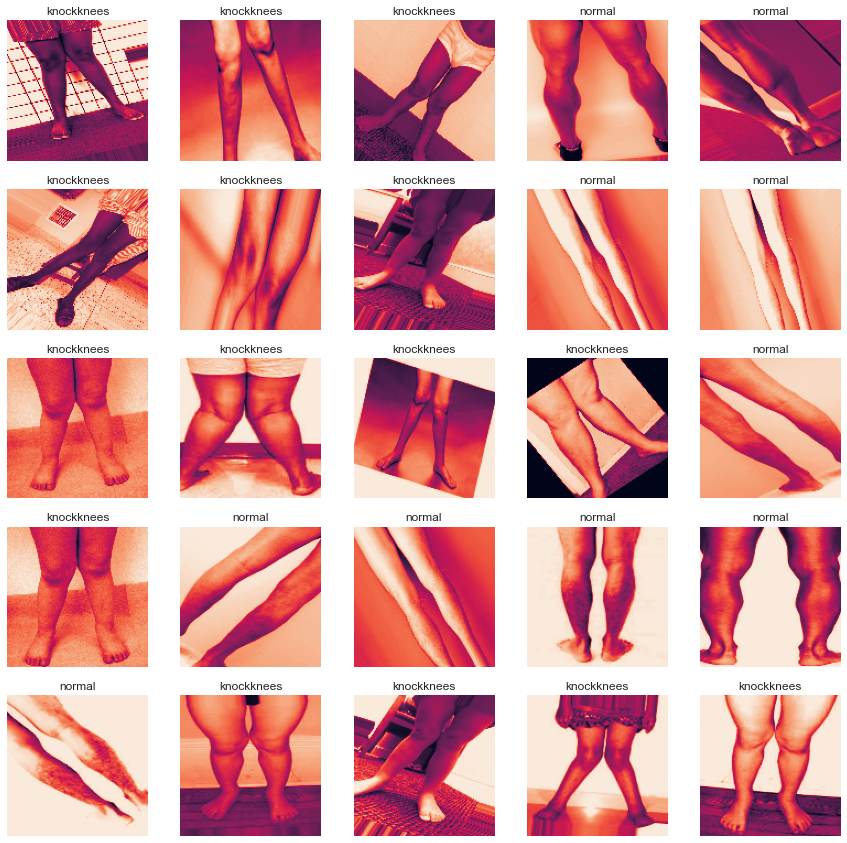

In [9]:
plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
    for i in range(25):
        
        plt.subplot(5, 5, i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype('uint8')))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')

In [10]:
training_dir = "X:/miniproject/train"
training_generator = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2 )
train_generator = training_generator.flow_from_directory(training_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 3185 images belonging to 2 classes.


In [11]:
validation_dir = "X:/miniproject/val"
validation_generator = ImageDataGenerator(rescale=1./255)
valid_generator = validation_generator.flow_from_directory(validation_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 72 images belonging to 2 classes.


In [12]:
testing_dir = "X:/miniproject/test"
testing_generator = ImageDataGenerator(rescale=1./255)
test_generator = testing_generator.flow_from_directory(testing_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 2616 images belonging to 2 classes.


In [13]:
ak=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(200,200,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [14]:
ak.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0

In [15]:
ak.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
history = ak.fit_generator(train_generator,
                           validation_data = valid_generator,
                           steps_per_epoch = 70,
                           epochs = 10,
                           verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
70/70 [==============================] - 15s 212ms/step - loss: 0.7246 - accuracy: 0.6786 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 2/10
70/70 [==============================] - 16s 233ms/step - loss: 0.6085 - accuracy: 0.6571 - val_loss: 0.6721 - val_accuracy: 0.5000
Epoch 3/10
70/70 [==============================] - 15s 218ms/step - loss: 0.5966 - accuracy: 0.6679 - val_loss: 0.5819 - val_accuracy: 0.5000
Epoch 4/10
70/70 [==============================] - 15s 209ms/step - loss: 0.6093 - accuracy: 0.6786 - val_loss: 0.5278 - val_accuracy: 0.8194
Epoch 5/10
70/70 [==============================] - 14s 203ms/step - loss: 0.5345 - accuracy: 0.6464 - val_loss: 0.5646 - val_accuracy: 0.8056
Epoch 6/10
70/70 [==============================] - 14s 200ms/step - loss: 0.5806 - accuracy: 0.6968 - val_loss: 0.5131 - val_accuracy: 0.7917
Epoch 7/10
70/70 [==============================] - 14s 200ms/step

<Figure size 432x288 with 0 Axes>

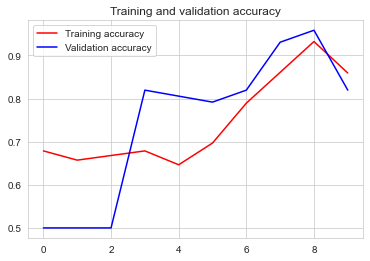

<Figure size 432x288 with 0 Axes>

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

In [18]:


print("Loss of the model is - " , ak.evaluate(test_generator)[0]*100 , "%")
print("Accuracy of the model is - " , ak.evaluate(test_generator)[1]*100 , "%")



654/654 [==============================] - 43s 66ms/step - loss: 0.2679 - accuracy: 0.8857
Loss of the model is -  26.794901490211487 %
654/654 [==============================] - 45s 69ms/step - loss: 0.2679 - accuracy: 0.8857
Accuracy of the model is -  88.57033848762512 %


In [24]:
tf.keras.models.save_model(ak, 'kk.hdf5')

In [25]:
!pip install streamlit

In [34]:
%%writefile app.py
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def main():
    model = tf.keras.models.load_model('/Documents/kk.hdf5')
    return model
model = main()
st.write(""" 
# Genu Valgum Detection
"""
        )
file = st.file_uploader("Please upload your legs Image", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):
    size = (128,128)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis,...]
    predition = moel.predict(img_reshape)
    return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    class_names = ['knockknees', 'normal']
    string = "This Image is Most likely is:" + class_name[np.argmax(predictions)]
    st.success(string)

if __name__ == '__main__':
    main()

Overwriting app.py


In [35]:
!ngrok authtoken 1komlBLfjjCtMlDq46mvTsZUbJa_7Scy8FJshzbj1ZwPAwQxC

Authtoken saved to configuration file: C:\Users\kumar/.ngrok2/ngrok.yml


In [38]:
!nohup streamlit run app.py &

OSError: Background processes not supported.